In [1]:
#Import packages
import numpy as np
from numpy import argmax
import pyspark.sql.functions as F
import snowflake.connector
import pandas as pd
import spacy
#from sparknlp.base import Finisher, DocumentAssembler
#from sparknlp.annotator import  Normalizer, LemmatizerModel, StopWordsCleaner, Tokenizer
#from pyspark.ml import Pipeline
#from pyspark.ml.feature import CountVectorizer, VectorAssembler, HashingTF, IDF, Tokenizer
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix, \
                            roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1602595798949_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#SPARK connection info
sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_PROD',
  'sfSchema' : 'ANALYTICS',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

#PYTHON connection info
conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user='APP_SPARK_PROD',
    password='>6txhcQ*7&^Qrq`j'
    )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Use review data set to get observation codes bc they are already comma separated and less joins to perform
#Still need observation set though to get observation created date
#This is bc review could be from ages ago but we could have imported recently and moderated it
#Want to make sure we include as many observation labels as possible for most accurate model



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
query = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.locale, r.observations, \
ADD IN CASE WHEN HERE \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2020-09-23'  \
limit 100"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
#Careful not to get CNR for NR
#CNR, NR, PM - contains(r.observations, ',NR,')
#NR, PM - substring(r.observations, 1, 2) = 'NR'
#CNR, PM - DONT WANT
#Careful not to get SSC for SC
#PM, SC - 
#PM, SSC - DONT WANT
#PM, SC, SSC
#18 labels total - not including PM (doesn't yet include NOLABEL label - 19 labels with that)
query_testing = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.reviewer_location, r.observations, \
case when contains(r.observations, 'PM') then 1 else 0 end as PM, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR, \
case when contains(r.observations, 'PII') then 1 else 0 end as PII, \
case when contains(r.observations, 'PR') then 1 else 0 end as PR, \
case when contains(r.observations, 'CS') then 1 else 0 end as CS, \
case when contains(r.observations, 'DC') then 1 else 0 end as DC, \
case when contains(r.observations, 'CR') then 1 else 0 end as CR, \
case when contains(r.observations, 'FRD') then 1 else 0 end as FRD, \
case when contains(r.observations, 'TST') then 1 else 0 end as TST, \
case when contains(r.observations, 'CC') then 1 else 0 end as CC, \
case when contains(r.observations, ',SC') then 1 else 0 end as SC, \
case when contains(r.observations, 'PIM') then 1 else 0 end as PIM, \
case when contains(r.observations, 'LC') then 1 else 0 end as LC, \
case when contains(r.observations, 'WEB') then 1 else 0 end as WEB, \
case when contains(r.observations, 'FL') then 1 else 0 end as FL, \
case when contains(r.observations, 'SA') then 1 else 0 end as SA, \
case when contains(r.observations, 'URL') then 1 else 0 end as URL, \
case when contains(r.observations, 'CV') then 1 else 0 end as CV, \
case when contains(r.observations, 'US') then 1 else 0 end as US \
from analytics.review as r \
where r.locale in ('en_US','en_GB','en_CA') \
and r.created_date > '2019-09-01'  \
and contains(r.observations, 'PM') \
limit 50000"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews = pd.read_sql(query_testing, conn)
reviews.head(100)
#reviews.info()

#PULLING IN ALL REVIEWS SINCE '2019-09-01' (17,468,653) TAKES X MINS

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID CREATED_DATE             REVIEW_HEADLINE  ... URL  CV US
0   288149711   2020-06-07  Not submitted by reviewer.  ...   0   0  0
1   288145566   2020-06-07  Not submitted by reviewer.  ...   0   0  0
2   288146799   2020-06-07                  Runs small  ...   0   0  0
3   288155846   2020-06-07              Comfy and cute  ...   0   0  0
4   288148735   2020-06-07  Not submitted by reviewer.  ...   0   0  0
..        ...          ...                         ...  ...  ..  .. ..
95  286212450   2020-06-07           Beach & Pool Time  ...   0   0  0
96  286212649   2020-06-07                        Soft  ...   0   0  0
97  286212745   2020-06-07                   White top  ...   0   0  0
98  286212718   2020-06-07  Not submitted by reviewer.  ...   0   0  0
99  286211410   2020-06-07   Perfect weight for summer  ...   0   0  0

[100 rows x 27 columns]

In [7]:
reviews.loc[reviews['REVIEWER_LOCATION'] == 'US', 'REVIEWER_LOCATION'] = 'USA'

#reviews['REVIEWER_LOCATION'].head(500)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
#Use set_option so text doesn't truncate
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#reviews['LABEL_SUM']= reviews.iloc[:, -18:-1].sum(axis=1)
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
#LOOK AT OTHER LABELS - IF NONE THEN ADD NOLABEL = 1
#df['new column name'] = df['column name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
#reviews['NOLABEL'] = reviews['LABEL_SUM'].apply(lambda x: int(1) if x==0 else int(0))

#df.loc[df['set_of_numbers'] <= 4, 'equal_or_lower_than_4?'] = 'True' 
#reviews.loc[reviews['NOLABEL'] == 0, 'TEST'] = 1
#df['Fruit Total']= df.iloc[:, -4:-1].sum(axis=1)
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
#reviews2 = reviews.drop(['LABEL_SUM'], axis=1)
#reviews2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
#reviews = reviews2
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

UGC_ID                        int64
CREATED_DATE         datetime64[ns]
REVIEW_HEADLINE              object
REVIEW_COMMENTS              object
REVIEW_RATING                 int64
REVIEWER_NICKNAME            object
REVIEWER_LOCATION            object
OBSERVATIONS                 object
PM                            int64
NR                            int64
PII                           int64
PR                            int64
CS                            int64
DC                            int64
CR                            int64
FRD                           int64
TST                           int64
CC                            int64
SC                            int64
PIM                           int64
LC                            int64
WEB                           int64
FL                            int64
SA                            int64
URL                           int64
CV                            int64
US                            int64
dtype: object

In [13]:
reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS'] + \
        ' nickname ' + reviews['REVIEWER_NICKNAME'] + ' location ' + reviews['REVIEWER_LOCATION']
#Use set_option so text doesn't truncate
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
reviews.head(100)

#reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID CREATED_DATE             REVIEW_HEADLINE  \
0   288149711 2020-06-07    Not submitted by reviewer.   
1   288145566 2020-06-07    Not submitted by reviewer.   
2   288146799 2020-06-07    Runs small                   
3   288155846 2020-06-07    Comfy and cute               
4   288148735 2020-06-07    Not submitted by reviewer.   
..        ...        ...                           ...   
95  286212450 2020-06-07    Beach & Pool Time            
96  286212649 2020-06-07    Soft                         
97  286212745 2020-06-07    White top                    
98  286212718 2020-06-07    Not submitted by reviewer.   
99  286211410 2020-06-07    Perfect weight for summer    

                                                                                                                                                                                                                                                                                                               

In [14]:
reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

UGC_ID               int64         
CREATED_DATE         datetime64[ns]
REVIEW_HEADLINE      object        
REVIEW_COMMENTS      object        
REVIEW_RATING        int64         
REVIEWER_NICKNAME    object        
REVIEWER_LOCATION    object        
OBSERVATIONS         object        
PM                   int64         
NR                   int64         
PII                  int64         
PR                   int64         
CS                   int64         
DC                   int64         
CR                   int64         
FRD                  int64         
TST                  int64         
CC                   int64         
SC                   int64         
PIM                  int64         
LC                   int64         
WEB                  int64         
FL                   int64         
SA                   int64         
URL                  int64         
CV                   int64         
US                   int64         
ALL_TEXT             object 

In [15]:


#reviews['PRICE'] = bool(re.match('location', str(reviews['ALL_TEXT'])))
#reviews[reviews['PRICE']==True].head()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          UGC_ID        CREATED_DATE  \
0      288149711 2020-06-07 00:00:00   
1      288145566 2020-06-07 00:00:00   
2      288146799 2020-06-07 00:00:00   
3      288155846 2020-06-07 00:00:00   
4      288148735 2020-06-07 00:00:00   
...          ...                 ...   
49995  277638347 2020-05-27 14:52:52   
49996  277635761 2020-05-27 13:37:09   
49997  277633833 2020-05-27 12:50:31   
49998  277633222 2020-05-27 12:36:08   
49999  277626958 2020-05-27 10:48:33   

                                                REVIEW_HEADLINE  \
0      Not submitted by reviewer.                                 
1      Not submitted by reviewer.                                 
2      Runs small                                                 
3      Comfy and cute                                             
4      Not submitted by reviewer.                                 
...                           ...                                 
49995  My 3rd pair.  Love 'me all!                

In [17]:
nlp = spacy.load("en_core_web_lg")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
reviews['vec'] = reviews['ALL_TEXT'].apply(lambda x: get_vec(x))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

object of type 'float' has no len()
Traceback (most recent call last):
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/series.py", line 4200, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas/_libs/lib.pyx", line 2402, in pandas._libs.lib.map_infer
  File "<stdin>", line 1, in <lambda>
  File "<stdin>", line 2, in get_vec
  File "/usr/local/lib64/python3.7/site-packages/spacy/language.py", line 437, in __call__
    if len(text) > self.max_length:
TypeError: object of type 'float' has no len()



In [20]:
reviews['vec'].shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'vec'
Traceback (most recent call last):
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/frame.py", line 2902, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/indexes/base.py", line 2897, in get_loc
    raise KeyError(key) from err
KeyError: 'vec'



In [21]:
X_text = reviews['vec'].to_numpy().reshape(-1,1)
X_text.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'vec'
Traceback (most recent call last):
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/frame.py", line 2902, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/indexes/base.py", line 2897, in get_loc
    raise KeyError(key) from err
KeyError: 'vec'



In [22]:
X_text = np.concatenate(np.concatenate(X_text, axis =0), axis = 0).reshape(-1, 300)
X_text.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'X_text' is not defined
Traceback (most recent call last):
NameError: name 'X_text' is not defined



In [23]:
ratings = (reviews['REVIEW_RATING']/5).to_numpy().reshape(-1,1)
ratings.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(50000, 1)

In [24]:
X = np.hstack([X_text, ratings])
X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'X_text' is not defined
Traceback (most recent call last):
NameError: name 'X_text' is not defined



In [25]:
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US','NOLABEL']]
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US']]
y = reviews[['NR']]
y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       NR
0      0 
1      0 
2      0 
3      0 
4      0 
...   .. 
49995  0 
49996  0 
49997  0 
49998  0 
49999  0 

[50000 rows x 1 columns]

In [26]:
y.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    1002
dtype: int64

In [27]:
#test_size is what % of data goes to test set vs training
#random_state - use so that when comparing models - same data is always going to test and train sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=9, stratify = y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'X' is not defined
Traceback (most recent call last):
NameError: name 'X' is not defined



In [28]:
print(xtrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'xtrain' is not defined
Traceback (most recent call last):
NameError: name 'xtrain' is not defined



In [29]:
print(ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'ytrain' is not defined
Traceback (most recent call last):
NameError: name 'ytrain' is not defined



In [30]:
#nlp = spacy.load("en_core_web_lg")
#tokens = nlp("dog cat banana afskfsd eyebrow lipliner 13")

#for token in tokens:
#    print(token.text, token.has_vector, token.vector_norm, token.is_oov, token.vector)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
#max_iter : default =100 but getting error about not converging
lr = LogisticRegression(max_iter=1000)
clf = OneVsRestClassifier(lr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
#UserWarning: Label not 17 is present in all training examples.
#Due to fact that 'US' does not appear in training set (is all 0s) 
#RESOLVES AS DATA SIZE INCREASES

#Getting max iteration exceeded error
#All TF-IDF features are range 0-1, scaled rating to be divided by 5 so that is also range 0-1
#Lower max_features for TF-IDF to reduce dimensionality


clf.fit(xtrain, ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'xtrain' is not defined
Traceback (most recent call last):
NameError: name 'xtrain' is not defined



In [33]:
#ytrain.dtypes
#NO US LABEL
ytrain.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'ytrain' is not defined
Traceback (most recent call last):
NameError: name 'ytrain' is not defined



In [34]:
y_pred = clf.predict(xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'xtest' is not defined
Traceback (most recent call last):
NameError: name 'xtest' is not defined



In [35]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
%matplotlib inline

In [37]:
#Confusion matrix
#confusion_matrix(ytest, y_pred)
#tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
#print("TN: {}".format(tn), "FP: {}".format(fp), "FN: {}".format(fn), "TP: {}".format(tp))
plot_confusion_matrix(clf, xtest, ytest)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'xtest' is not defined
Traceback (most recent call last):
NameError: name 'xtest' is not defined



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

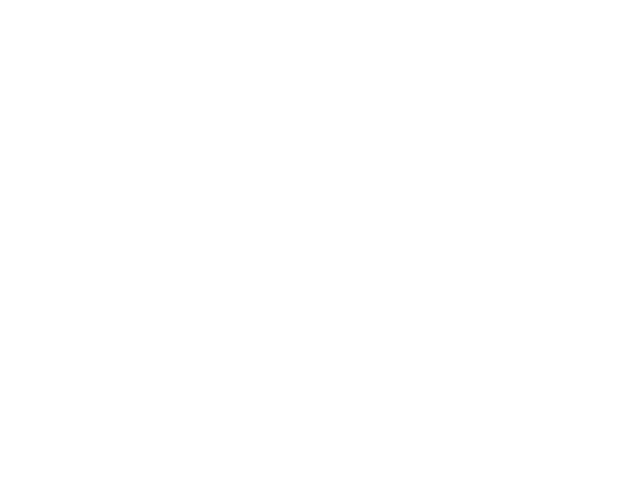

In [38]:
%matplot plt

In [39]:
#Evaluating model performance
#There are inherently mostly NOLABEL so accuracy could be high just bc of those
#Want to make sure that when there is a label besides NOLABEL that it is being accurately predicted


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
#Model performance metrics
#Assess at individual label level as well as overall

#Accuracy is overall correct predictions - not great measurement tool for imbalanced data
#Precision - TP / TP + FP = spam detection - don't want to mark something as spam (FP) when it isn't
#Recall - TP / TP + FN = sickness - don't want to tell someone they aren't sick (FN) when they are and can spread it
#F1 - balance of precision and recall

#We want to make sure if bomb emoji then it gets marked - even at the expense of marking other things potentially offensive that aren't 
#Important not to have FN - USE RECALL
#Also don't want to be marking a bunch of stuff as offensive when it isn't and making moderation do everything anyway
#Important not to have too many FP - USE PRECISION
#Use F1 for balance between both
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'ytest' is not defined
Traceback (most recent call last):
NameError: name 'ytest' is not defined



In [41]:
print(classification_report(ytest,y_pred))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'ytest' is not defined
Traceback (most recent call last):
NameError: name 'ytest' is not defined



In [42]:
probs = clf.predict_proba(xtest)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'xtest' is not defined
Traceback (most recent call last):
NameError: name 'xtest' is not defined



In [43]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
#ROC CURVE
#Assumes we care about 0 and 1 classification the same - we don't
#We care more about performance of 1 classification - use precision recall curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'fpr' is not defined
Traceback (most recent call last):
NameError: name 'fpr' is not defined



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

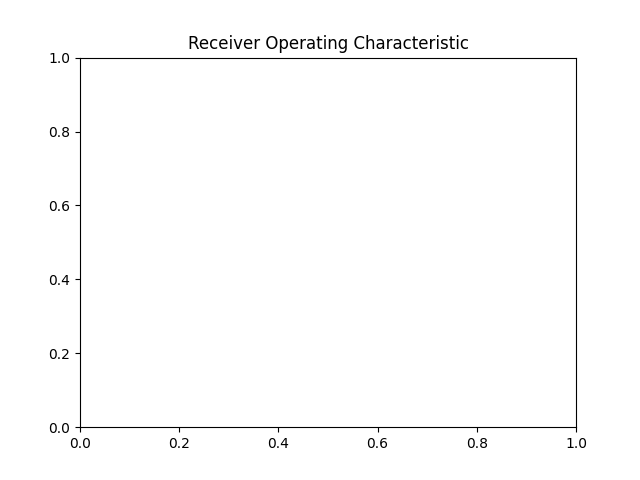

In [45]:
%matplot plt

In [46]:
#Find best threshold (ROC Curve)
#Ideally want tpr = 1 and fpr = 0, so want tpr - fpr as close to 1 as possible
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
opt_tpr = tpr[optimal_idx]
opt_fpr = fpr[optimal_idx]
print("Optimal threshold value:", optimal_threshold)
print("Optimal tpr value:", opt_tpr)
print("Optimal fpr value:", opt_fpr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'tpr' is not defined
Traceback (most recent call last):
NameError: name 'tpr' is not defined



In [106]:
t = optimal_threshold
y_pred_new = (preds >= t).astype(int)
#y_pred_new

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [107]:
#Scores with best threshold cutoff
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred_new)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred_new)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred_new)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred_new)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.8126
Precision is:  0.08509591736350221
Recall is:  0.9251336898395722
F1 Score is:  0.15585585585585582

In [108]:
len(y_pred_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

10000

In [109]:
#PRECISION RECALL CURVE
#Better for what we want to assess which is how well label is assigned (i.e. when it gets a 1 instead of a 0)

precision, recall, pr_threshold = precision_recall_curve(ytest, preds)
auc = auc(recall, precision)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [110]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [111]:
plt.title('Precision - Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc = 'lower right')
no_skill = len(ytest[ytest['NR']==1]) / len(ytest)
plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

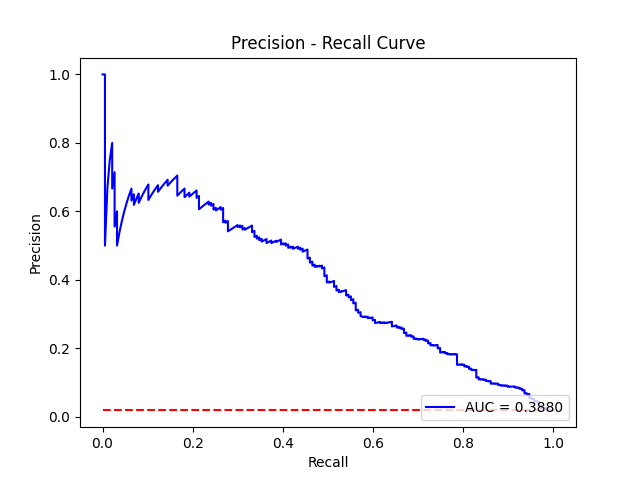

In [112]:
%matplot plt

In [113]:
#Best F1 score optimizes precision recall trade off

fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (pr_threshold[ix], fscore[ix]))

print('Recall=%f' % recall[ix])
print('Precision=%f' % precision[ix])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Threshold=0.228202, F-Score=0.471
Recall=0.454545
Precision=0.488506

In [122]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [123]:
plt.hist(preds, bins=10)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

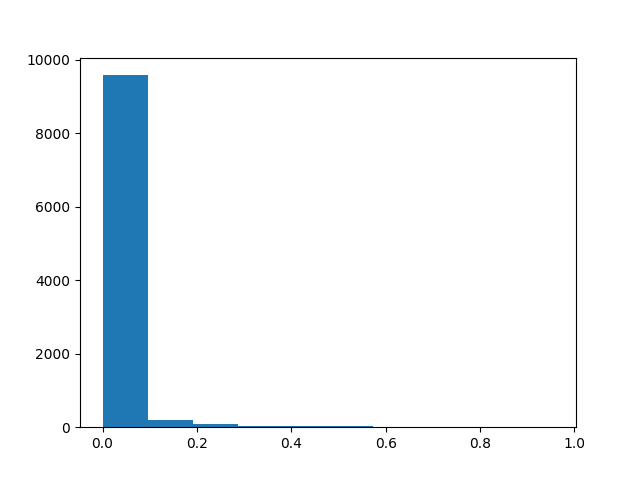

In [124]:
%matplot plt

In [114]:
#LOGISTIC REGRESSION

#Single tokens
#data set = 500,000
#max_features = 30000
#Best Threshold=0.209417, F-Score=0.498
#Recall 0.49516908212560384
#Precision 0.5012224938875306


#Single tokens
#data set = 500,000
#max_features = 50000
#Best Threshold=0.200349, F-Score=0.499
#Recall=0.504227
#Precision=0.494083

#Single tokens
#data set = 5,000,000
#max_features = 50000
#Best Threshold=0.200349, F-Score=0.499
#Recall=0.504227
#Precision=0.494083

#2 n-grams
#data set = 5,000,000
#max_features = 50000
#Best Threshold=0.221356, F-Score=0.484
#Recall=0.471806
#Precision=0.495870

#3 n-grams
#data set = 5,000,000
#max_features = 50000 or 30000
#BOTH MAX FEATURE SIZES GIVE MEMORY ERROR

#Word embeddings
#data set = 500,000
#Best Threshold=0.228202, F-Score=0.471
#Recall=0.454545
#Precision=0.488506

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…